### **Imports**

In [19]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import chi2
from sko.PSO import PSO
from sklearn.feature_selection import chi2
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from scipy.stats import ttest_rel
from statistics import mean, stdev
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


### **Data Ingestion**

In [ ]:
# Carregamento de Dados
test = pd.read_csv(r'../datasets/test_data_cleaned.csv')
train = pd.read_csv(r'../datasets/training_data_cleaned.csv')
train = train.drop(columns=['hour', 'AVERAGE_WIND_SPEED'])
test = test.drop(columns=['hour', 'AVERAGE_WIND_SPEED'])

### **Data Segregation**

In [21]:
y = train['AVERAGE_SPEED_DIFF']
X = train.drop(columns=['AVERAGE_SPEED_DIFF'])
X_test = test

### **Model Training**

### *XGboost*

In [22]:
# 1. Separar um conjunto de validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2025
)

# 2. Configurar o Pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=2025)),
    ('model', XGBClassifier(random_state=2025))
])

# 3. Definir a estratégia de CV, Stratified K-Fold
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=2025)

param_grid = {
    'model__n_estimators': [120],
    'model__max_depth': [3, 6],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

# 4. GridSearch com StratifiedKFold integrado
model = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring='f1_macro',
    n_jobs=-1
)

model.fit(X_train, y_train)

# 5. Resultados
print(f"Melhores parâmetros encontrados: {model.best_params_}")
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

Melhores parâmetros encontrados: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 120, 'model__subsample': 1}
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       431
           1       0.68      0.77      0.72       275
           2       0.84      0.78      0.81       357
           3       0.78      0.76      0.77       208
           4       0.80      0.80      0.80        92

    accuracy                           0.81      1363
   macro avg       0.80      0.80      0.80      1363
weighted avg       0.82      0.81      0.81      1363

0.8121790168745414


### **Feature Importance**

#### **FI based on Mean Decrease in Impurity (MDI) (Model Specific)**

In [23]:
start_time = time.time()

# Access the best estimator (Pipeline) and then the XGBoost model step named 'model'
best_model = model.best_estimator_.named_steps['model']

mdi_importances = best_model.feature_importances_
booster = best_model.get_booster()
tree_scores = []
for i in range(len(booster.get_dump())):
    # Obter importâncias para cada árvore isolada
    score = booster.get_score(importance_type='weight', fmap='')
    # score vem como dict {feature_name: importance}, convertemos para array alinhado
    tree_scores.append([score.get(f"f{j}", 0) for j in range(len(mdi_importances))])

std = np.std(tree_scores, axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.482 seconds


Feature importances using MDI:
 AVERAGE_TIME_DIFF          0.279745
LUMINOSITY                 0.249152
hour_sin                   0.065630
AVERAGE_FREE_FLOW_SPEED    0.064856
hour_cos                   0.062986
dayofweek                  0.037301
year                       0.034172
month                      0.030198
AVERAGE_RAIN               0.029330
AVERAGE_FREE_FLOW_TIME     0.026392
week                       0.024268
dayofyear                  0.023728
AVERAGE_TEMPERATURE        0.020415
AVERAGE_CLOUDINESS         0.020108
AVERAGE_HUMIDITY           0.015929
AVERAGE_ATMOSP_PRESSURE    0.015790
dtype: float32


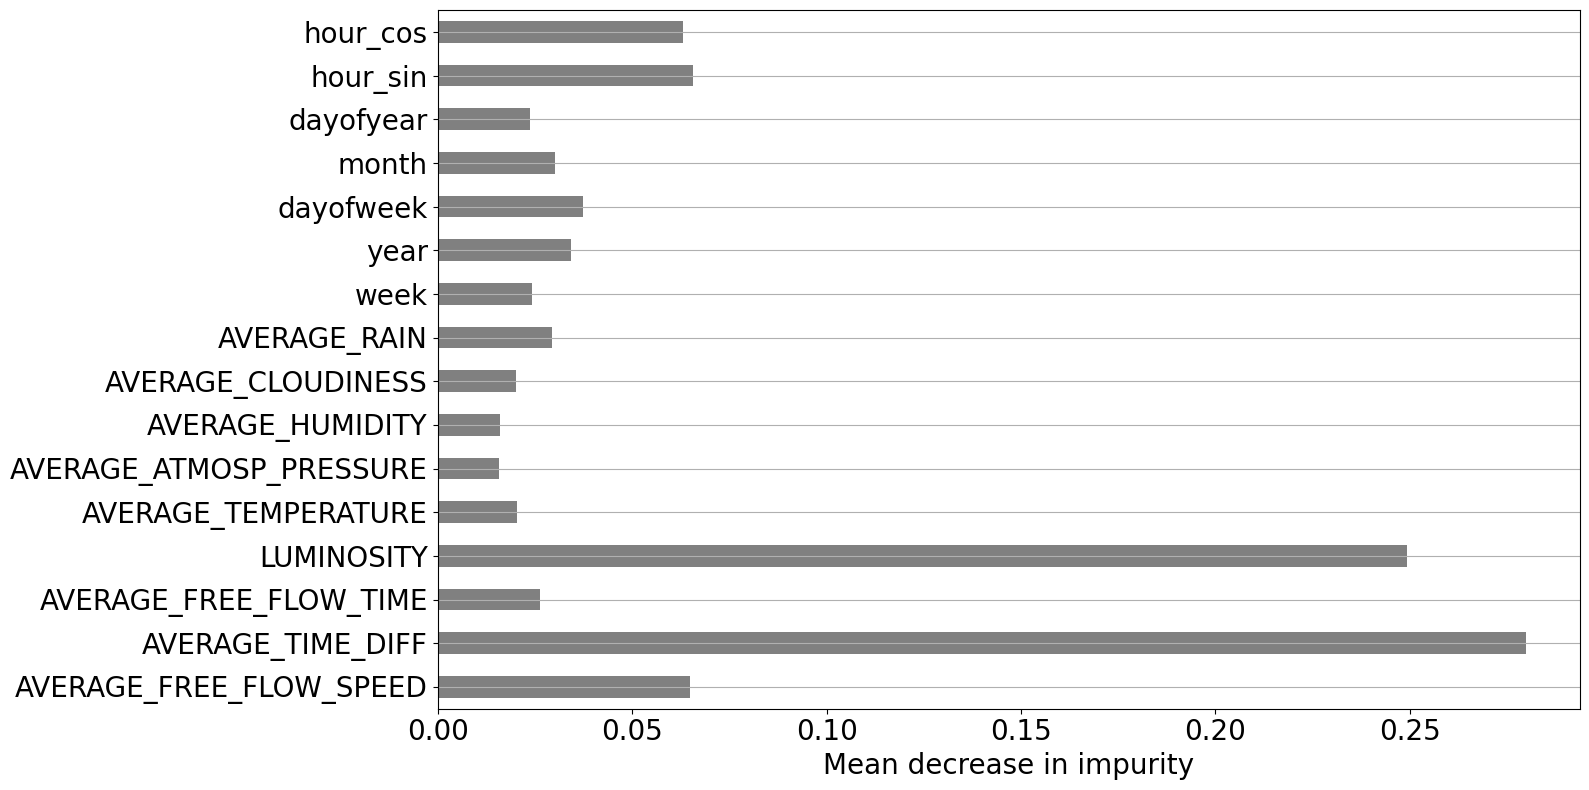

In [24]:
mdi_importances_series = pd.Series(mdi_importances, index=X_val.columns)
print("Feature importances using MDI:\n", mdi_importances_series.sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(16,8))
mdi_importances_series.plot.barh(ax=ax, color='grey')
ax.grid(axis='y')
ax.set_xlabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
fig.tight_layout()
plt.show()

#### **FI based on Permutation Importance (Model Agnostic)**

In [25]:
start_time = time.time()

result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 6.193 seconds


Feature importances using PI:
 AVERAGE_TIME_DIFF          0.562252
AVERAGE_FREE_FLOW_SPEED    0.077744
hour_sin                   0.031143
AVERAGE_FREE_FLOW_TIME     0.023991
dayofweek                  0.021527
hour_cos                   0.012730
dayofyear                  0.003923
AVERAGE_CLOUDINESS         0.001658
year                       0.000713
AVERAGE_ATMOSP_PRESSURE   -0.000042
AVERAGE_RAIN              -0.000064
month                     -0.000110
AVERAGE_HUMIDITY          -0.000161
week                      -0.000187
AVERAGE_TEMPERATURE       -0.000416
LUMINOSITY                -0.001812
dtype: float64


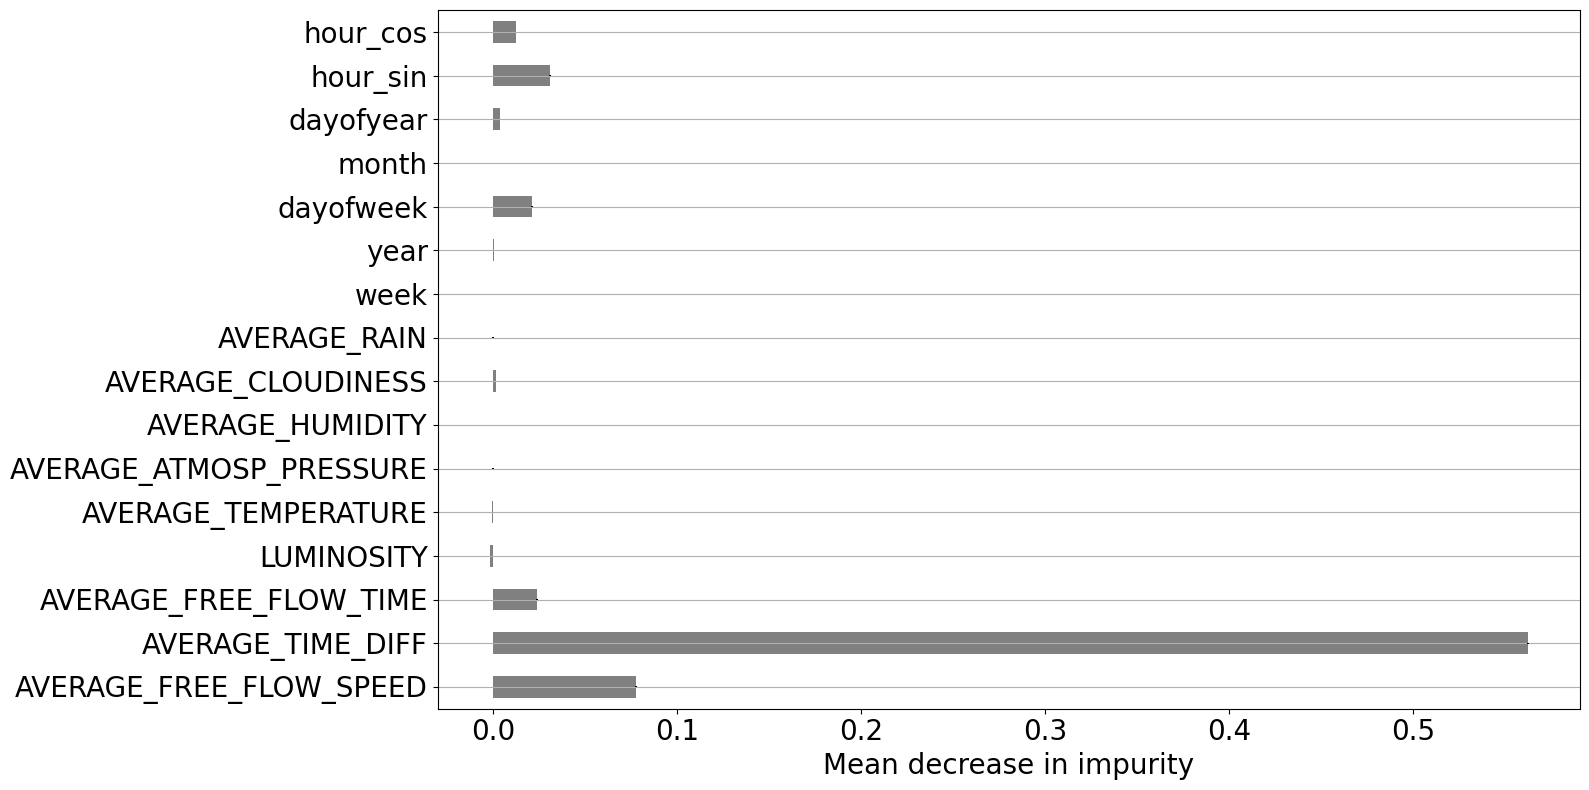

In [26]:
p_importances = pd.Series(result.importances_mean, index=X_val.columns)
print("Feature importances using PI:\n", p_importances.sort_values(ascending=False))
fig, ax = plt.subplots(figsize=(16,8))
p_importances.plot.barh(yerr=result.importances_std, ax=ax,color='grey')
ax.grid(axis='y')
ax.set_xlabel("Mean decrease in impurity", fontsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)
fig.tight_layout()
plt.show()

#### **Shap**

In [27]:
shap.initjs()

In [28]:
explainer = shap.Explainer(model.predict_proba, X_test)
shap_values = explainer(X_test)

PermutationExplainer explainer: 1501it [04:41,  5.15it/s]                          


##### **Local Interpretability**

Previsão de AVERAGE_SPEED_DIFF para esta amostra: 1 (Low)


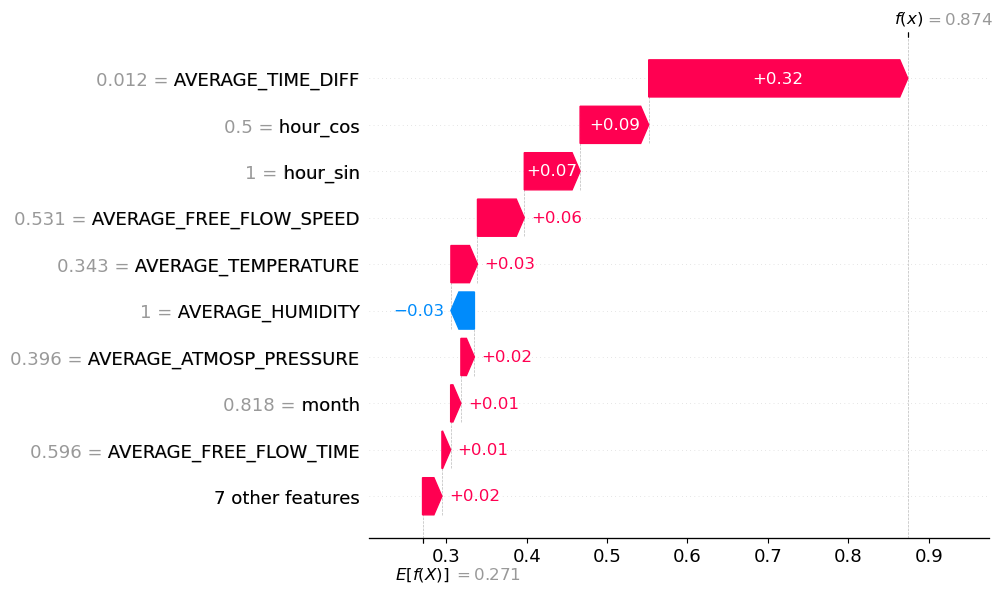

In [29]:
# 1. Escolher a linha (amostra) que quer analisar
no = 4

# 2. Fazer a previsão
# Usar .iloc[[no]] mantém o formato de DataFrame, o que ajuda o modelo a manter os nomes das colunas
prediction = model.predict(X_test.iloc[[no]])[0]
inverse_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
print(f"Previsão de AVERAGE_SPEED_DIFF para esta amostra: {prediction} ({inverse_map[prediction]})")

# 3. Plotar o Waterfall
# Para classificação multiclasse, precisamos especificar a classe
# shap_values[no] tem shape (12, 5) - precisamos escolher uma classe
# Vamos visualizar a classe predita
shap.plots.waterfall(shap_values[no, :, prediction])

##### **Global Interpretability**

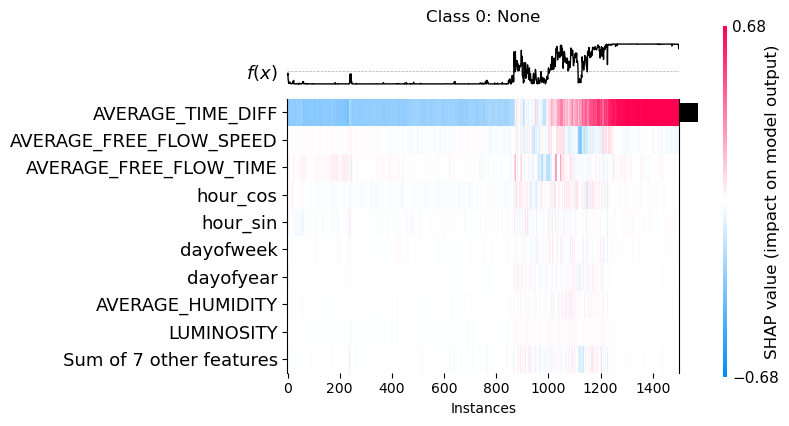

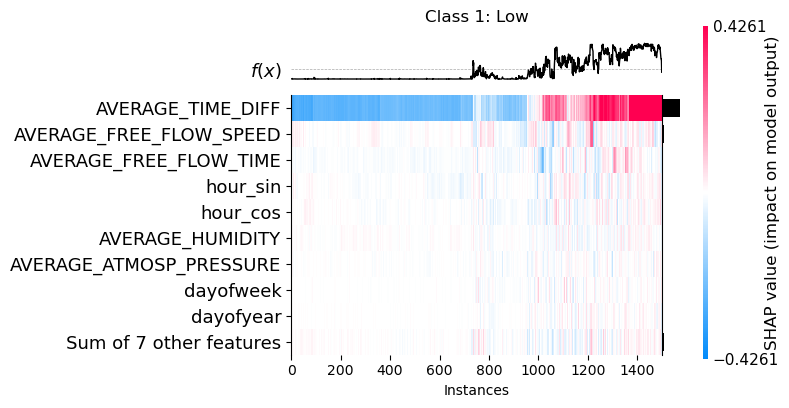

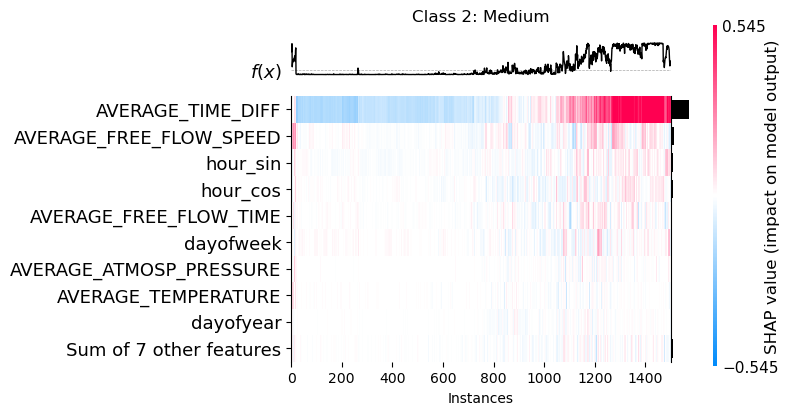

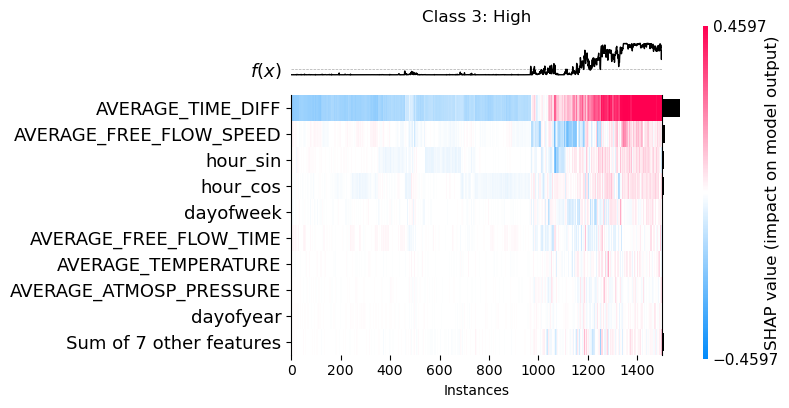

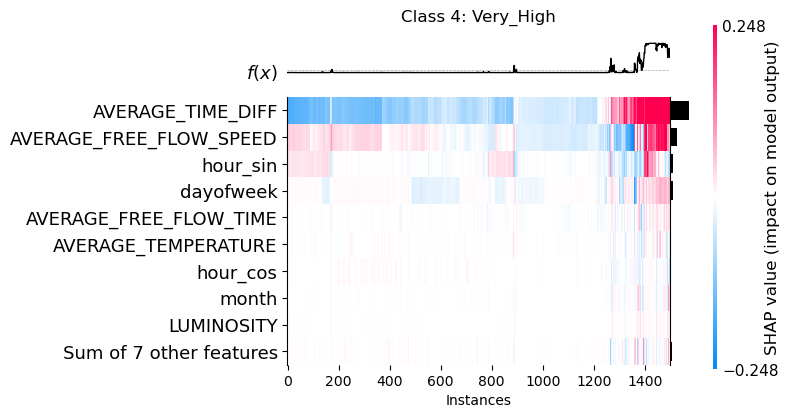

In [30]:
# For multiclass classification, visualize SHAP values for a specific class
# 0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'

shap.plots.heatmap(shap_values[:, :, 0], show=False)
plt.title("Class 0: None")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 1], show=False)
plt.title("Class 1: Low")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 2], show=False)
plt.title("Class 2: Medium")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 3], show=False)
plt.title("Class 3: High")
plt.tight_layout()
plt.show()

shap.plots.heatmap(shap_values[:, :, 4], show=False)
plt.title("Class 4: Very_High")
plt.tight_layout()
plt.show()

##### **Feature wise**

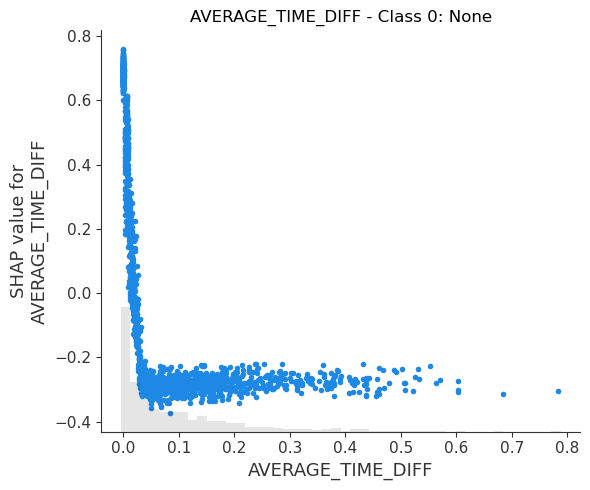

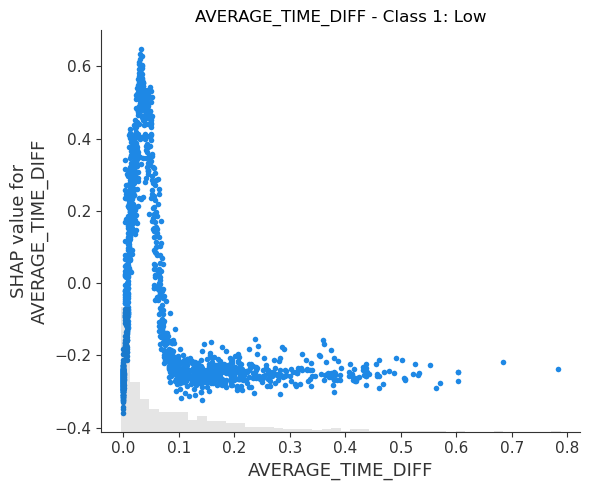

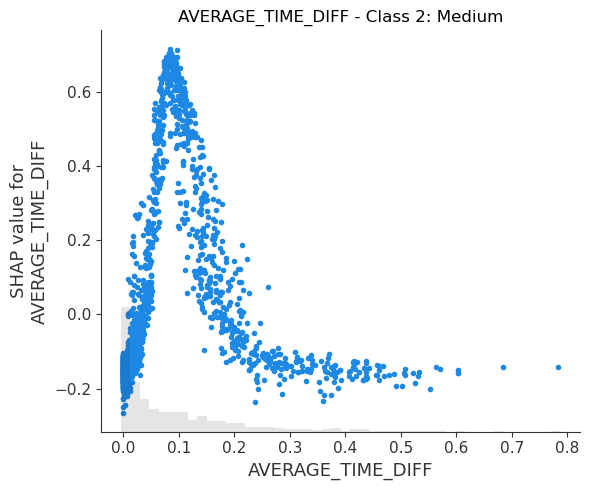

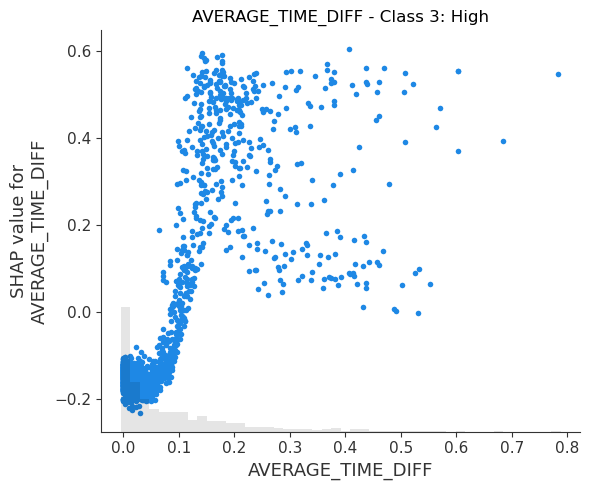

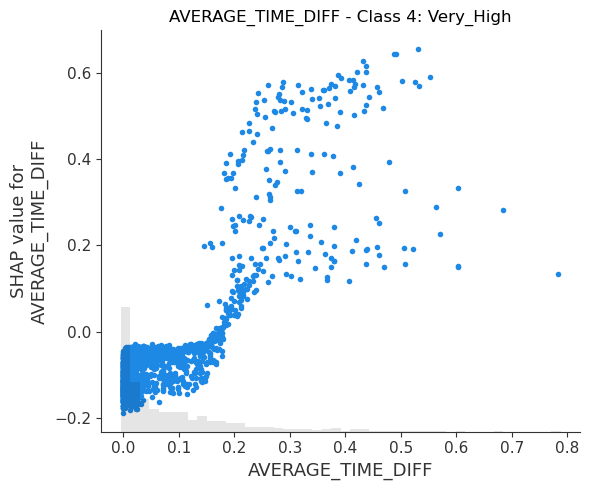

In [31]:
# Beeswarm plots for AVERAGE_TIME_DIFF feature across all classes
shap.plots.scatter(shap_values[:,"AVERAGE_TIME_DIFF",0], show=False)
plt.title("AVERAGE_TIME_DIFF - Class 0: None")
plt.tight_layout()
plt.show()

shap.plots.scatter(shap_values[:,"AVERAGE_TIME_DIFF",1], show=False)
plt.title("AVERAGE_TIME_DIFF - Class 1: Low")
plt.tight_layout()
plt.show()

shap.plots.scatter(shap_values[:,"AVERAGE_TIME_DIFF",2], show=False)
plt.title("AVERAGE_TIME_DIFF - Class 2: Medium")
plt.tight_layout()
plt.show()

shap.plots.scatter(shap_values[:,"AVERAGE_TIME_DIFF",3], show=False)
plt.title("AVERAGE_TIME_DIFF - Class 3: High")
plt.tight_layout()
plt.show()

shap.plots.scatter(shap_values[:,"AVERAGE_TIME_DIFF",4], show=False)
plt.title("AVERAGE_TIME_DIFF - Class 4: Very_High")
plt.tight_layout()
plt.show()

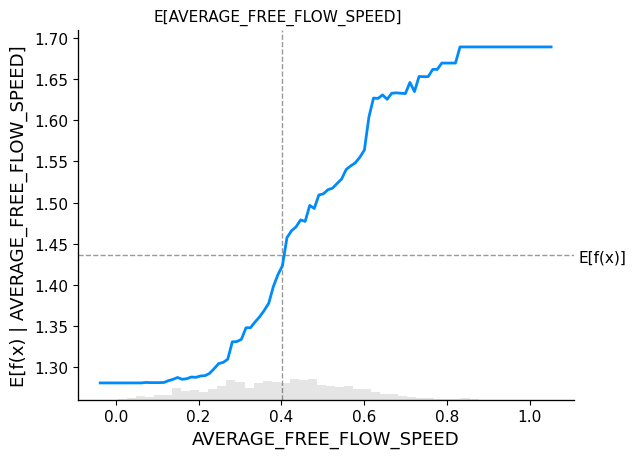

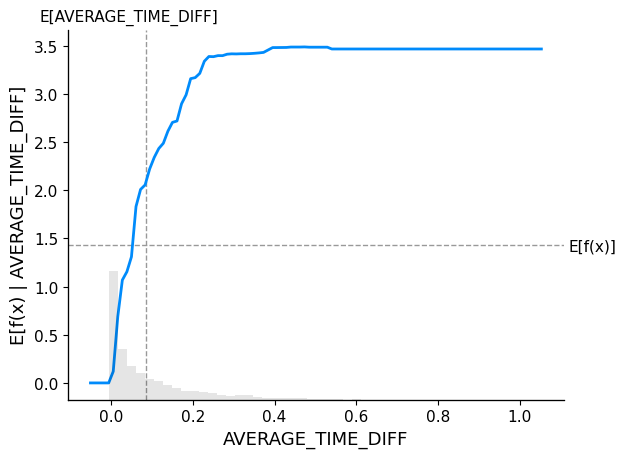

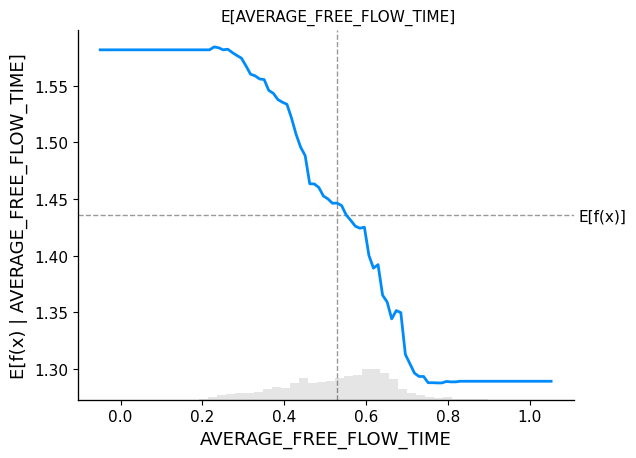

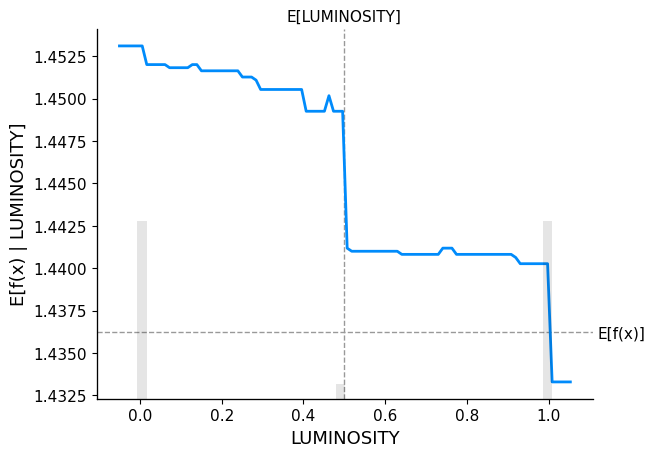

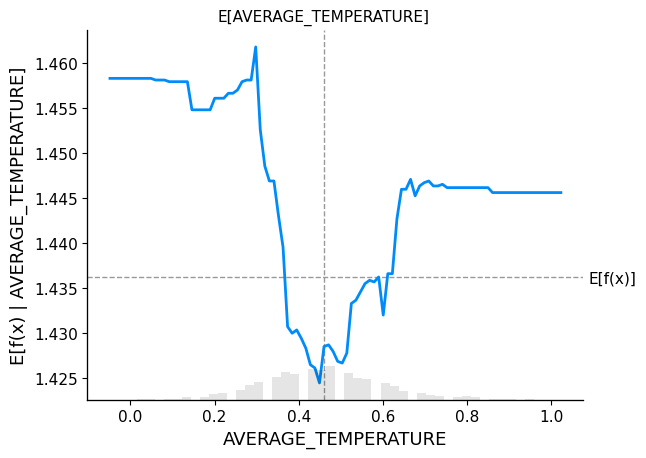

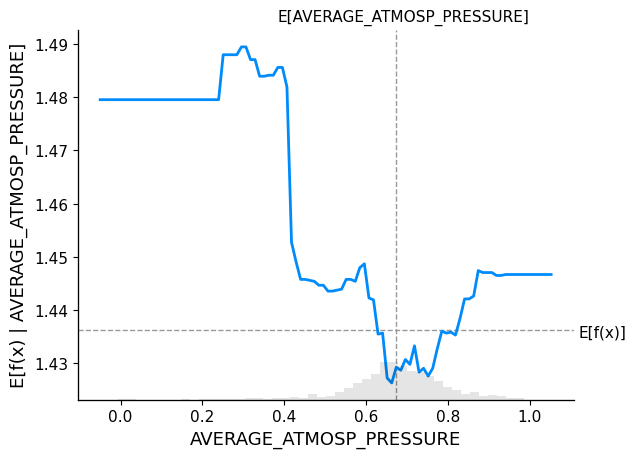

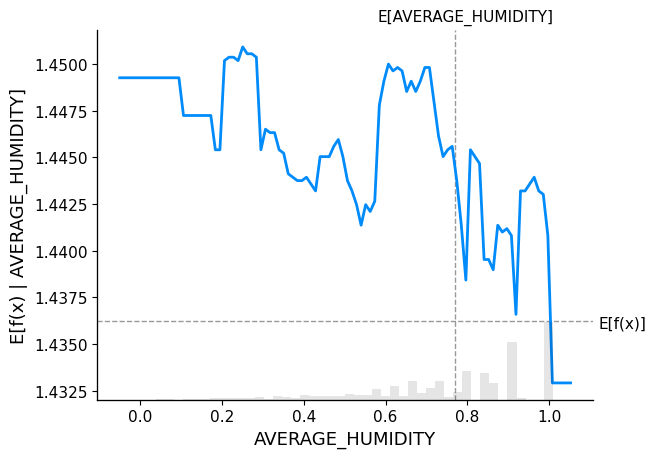

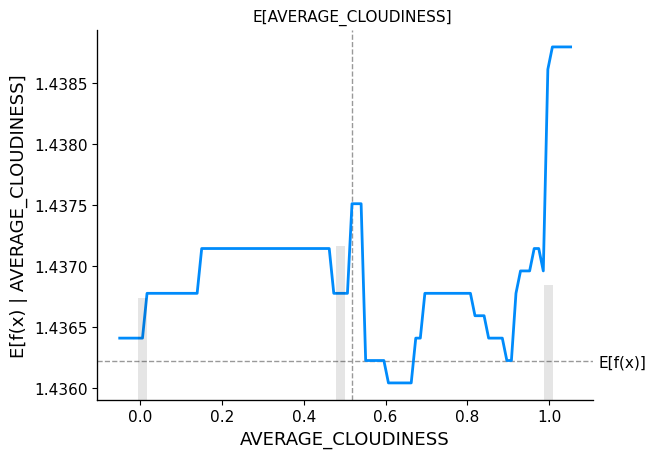

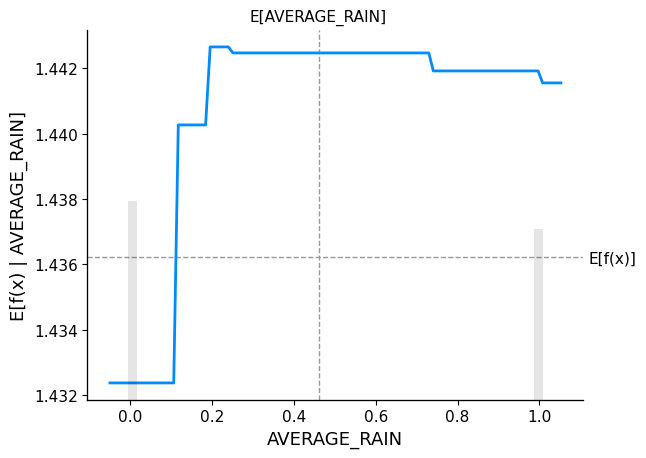

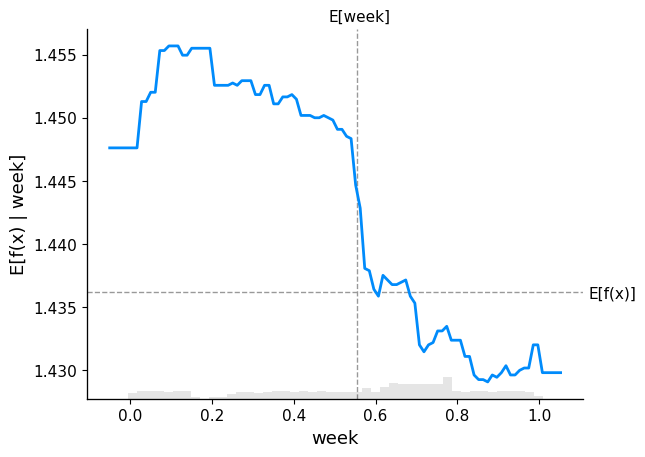

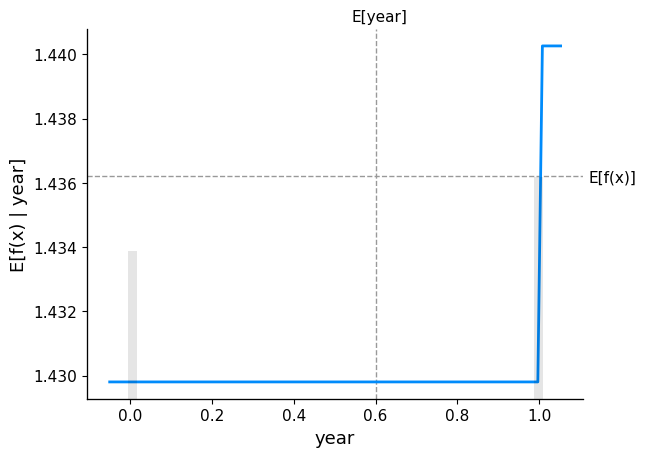

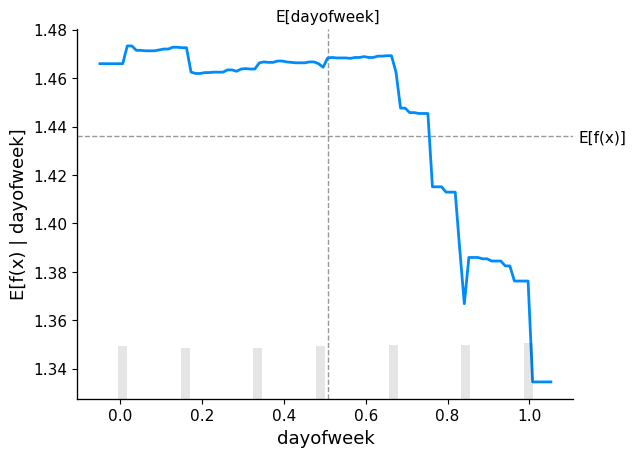

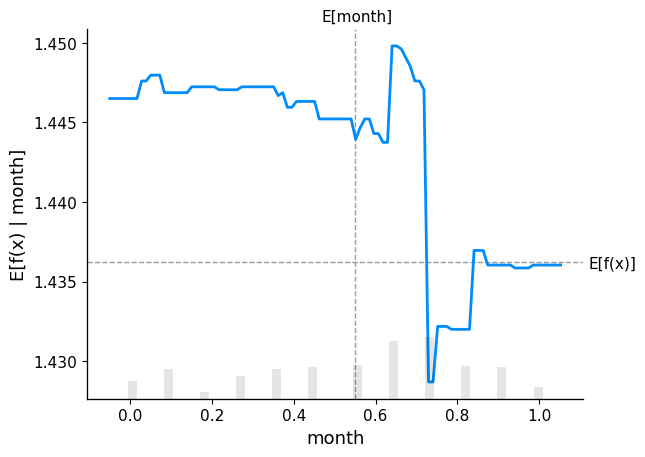

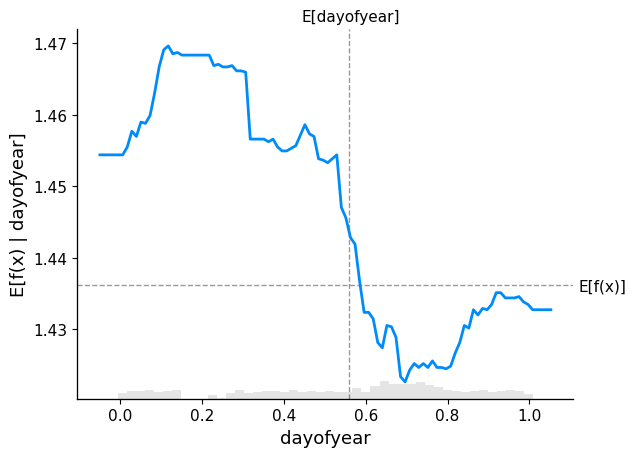

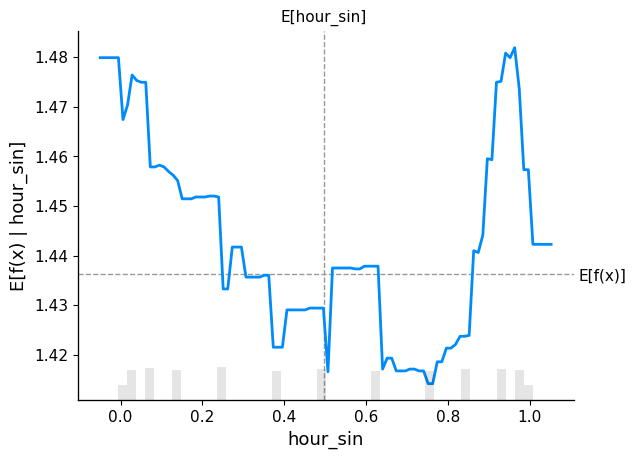

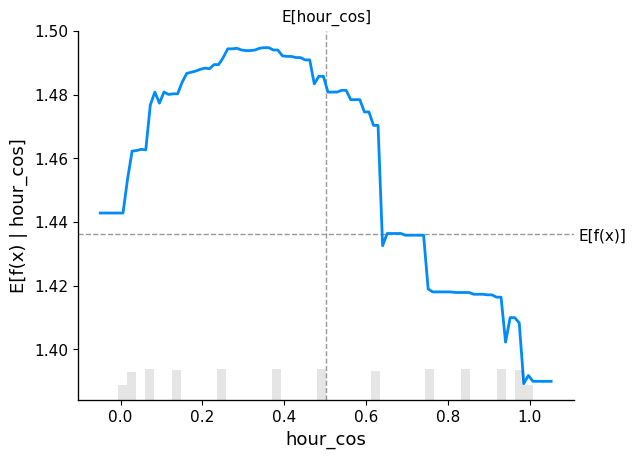

In [32]:
feature = X_train.columns[0]
for feature in X_train.columns:
    shap.partial_dependence_plot(feature, model.predict, X_train, ice=False, model_expected_value=True, feature_expected_value=True)

### **Submission Preparation**

In [33]:
# Exportar modelo treinado
import joblib
joblib.dump(model, 'XGBoost.pkl')

['XGBoost.pkl']

In [34]:
# Previsões no conjunto de teste
y_test = model.predict(X_test)

In [35]:
# Desmapeamento dos valores preditos para as categorias originais
inverse_map = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very_High'}
y_test = pd.Series(y_test).map(inverse_map)

In [36]:
# Criar CSV de submissão
submission = pd.DataFrame({'RowId': range(1, len(X_test)+1), 'Speed_Diff': y_test})
submission.to_csv('submission.csv', index=False)